In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../training",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 1 1 0 0 1 1 1 1 1 0 2 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1]


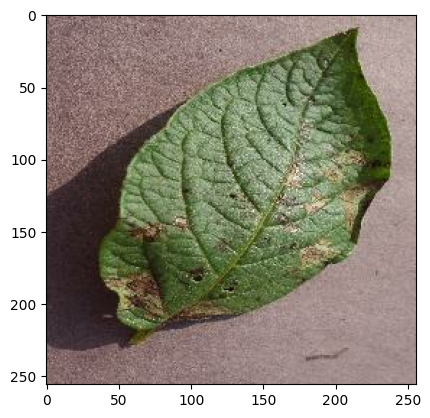

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    # print(image_batch[0].numpy())
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [6]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [7]:
def get_dataset_partitions (ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)

    if (shuffle):
        ds = ds.shuffle(shuffle_size, 12)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [9]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [26]:
from keras.layers import Dropout

# Resize and rescale layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Define input shape without batch size
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout after the first convolutional layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout after the second convolutional layer
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    Dropout(0.5),  # Add dropout before the output layer
    layers.Dense(n_classes, activation='softmax'),
])

# Model build without specifying input_shape
model.build(input_shape=(None,) + input_shape)


In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.4904 - loss: 1.6264 - val_accuracy: 0.7969 - val_loss: 0.8446
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6791 - loss: 0.7121 - val_accuracy: 0.8542 - val_loss: 0.4866
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8374 - loss: 0.4786 - val_accuracy: 0.8333 - val_loss: 0.3828
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8525 - loss: 0.3854 - val_accuracy: 0.8333 - val_loss: 0.3600
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8695 - loss: 0.3244 - val_accuracy: 0.8906 - val_loss: 0.2052
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8661 - loss: 0.2971 - val_accuracy: 0.9167 - val_loss: 0.1731
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9182 - loss: 0.2228 - val_accuracy: 0.9531 - val_loss: 0.1741
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9134 - loss: 0.2621 - val_accuracy: 0.9219 - val_los

In [34]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.9573 - loss: 0.0926


In [35]:
scores

[0.12339375913143158, 0.94140625]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

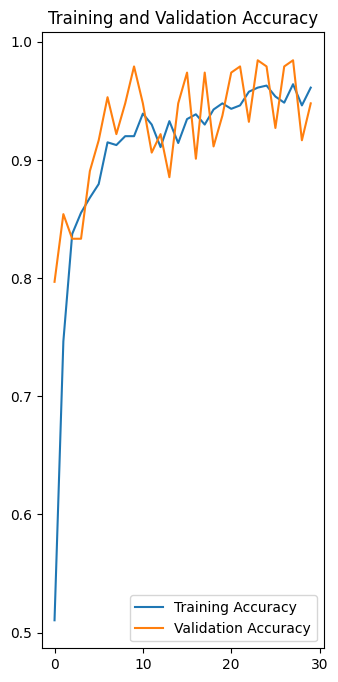

In [37]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

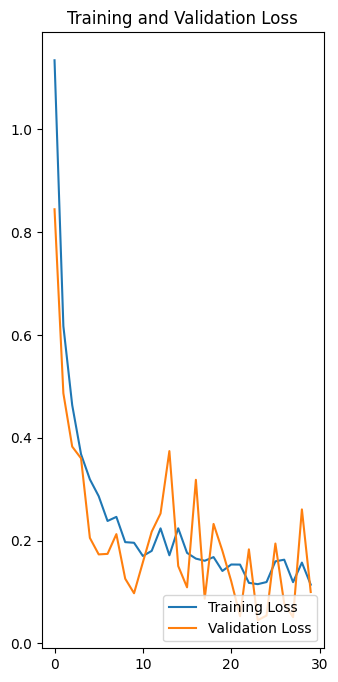

In [38]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

Image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
Actual label: Potato___Early_blight
Predicted label: Potato___Early_blight


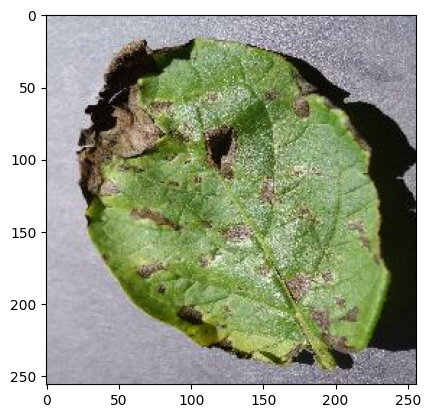

In [39]:
import numpy as np
import random as rnd

for images_batch, labels_batch in test_ds.take(1):
    random_number = rnd.randint(0, 31)
    image = images_batch[random_number].numpy().astype('uint8')
    label = labels_batch[random_number].numpy()

print("Image:")
plt.imshow(image)

batch_prediction = model.predict(images_batch)

print("Actual label:", class_names[label])
print("Predicted label:", class_names[np.argmax(batch_prediction[random_number])])

# softmax returns a probability for each label, choose the max